# MuhRec in python demonstration

In [1]:
import sys, os
sys.path.insert(0, "/home/kaestner/git/install/lib")
sys.path.insert(0, "/home/kaestner/git/scripts/python/")
if 'LD_LIBRARY_PATH' not in os.environ:
    os.environ['LD_LIBRARY_PATH'] = '/home/kaestner/git/install/lib'
   # os.execv(sys.argv[0], sys.argv)




In [2]:
import numpy as np
import muhrectomo as mt
import matplotlib.pyplot as plt
import imgalg
import amglib.readers as io
import amglib.imageutils as amg

In [3]:
import importlib
importlib.reload(mt)
importlib.reload(io)
importlib.reload(amg)
importlib.reload(imgalg)

<module 'imgalg' from '/home/kaestner/git/install/lib/imgalg.cpython-38-x86_64-linux-gnu.so'>

## Create a reconstructor object

In [4]:
recon = mt.Reconstructor(mt.bpMultiProj)

print("Created reconstructor :",recon.name())

Created reconstructor : Multi projection BP


## Reconstruction workflow

### Numerical dummy
This dummy is only to test the connection and that the reconstructor starts at all. Only nonsense data.

In [5]:
Nproj = 10
proj = np.ones([Nproj,256,256])

In [6]:
args = {"angles" : np.linspace(0,180,num=Nproj), 
        "weights" : np.ones(Nproj)}

In [7]:
recon.configure({   "center" : 50, 
                    "resolution" : 0.135
                })

In [8]:
recon.process(proj,args)

vol = recon.volume()

256 256 10


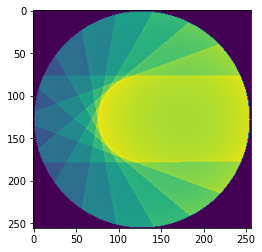

In [9]:
plt.imshow(vol[0])

### The wood data
The wood data is the data I use a lot for demos, tests, and tutorials. It a piece of petrified wood [DOI](http://dx.doi.org/10.17632/g5snr785xy.2). 

#### Load projection data

In [11]:
ob = io.readImages('/home/kaestner/data/wooddata/projections/ob_{0:04d}.tif',1,5,averageStack=True).mean(axis=0)
dc = io.readImages('/home/kaestner/data/wooddata/projections/dc_{0:04d}.tif',1,5,averageStack=True).mean(axis=0)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [12]:
proj = io.readImages('/home/kaestner/data/wooddata/projections/wood_{0:04d}.tif',1,626) # This takes a while

  0%|          | 0/625 [00:00<?, ?it/s]

In [13]:
proj.dtype

dtype('float32')

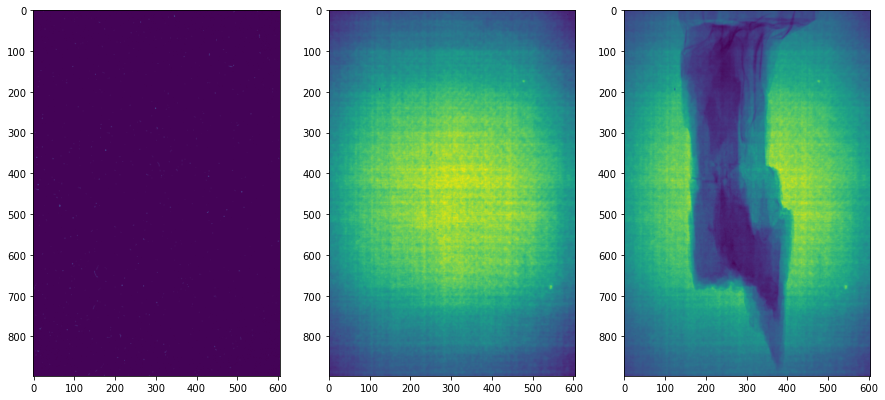

In [14]:
fig,ax = plt.subplots(1,3,figsize=[15,7])
ax[0].imshow(dc)
ax[1].imshow(ob)
ax[2].imshow(proj[0])


## Preprocessing
Here the projections needs to be prepared for reconstruction. Typical operations are 
- Cropping
- Normalization (possibly with scattering correction)
- Spot cleaning
- Ring cleaning

### Normalize - the kipl way

In [13]:
help(imgalg)

Help on module imgalg:

NAME
    imgalg

CLASSES
    builtins.Exception(builtins.BaseException)
        ImagingException
    pybind11_builtins.pybind11_object(builtins.object)
        AverageImage
        MorphSpotClean
        NormalizeImage
        PolynomialCorrection
        ProjectionFilter
        StripeFilter
        TomoCenter
        eCenterEstimator
        eMorphCleanMethod
        eMorphDetectionMethod
        eProjectionFilterType
        eStripeFilterOperation
    
    class AverageImage(pybind11_builtins.pybind11_object)
     |  Method resolution order:
     |      AverageImage
     |      pybind11_builtins.pybind11_object
     |      builtins.object
     |  
     |  Methods defined here:
     |  
     |  __init__(...)
     |      __init__(self: imgalg.AverageImage) -> None
     |  
     |  process(...)
     |      process(self: imgalg.AverageImage, img: numpy.ndarray[float32], method: ImagingAlgorithms::AverageImage::eAverageMethod, weights: List[float]=[]) -> numpy.nda

In [15]:
norm = imgalg.NormalizeImage(True) # True for use logarithm

In [16]:
norm.usingLog()

True

In [17]:
norm = imgalg.NormalizeImage(True) # True for use logarithm
norm.setReferences(ob,dc)
cproj = proj.copy()
norm.process(cproj)

## Normalize - the python way

In [17]:
nproj = amg.normalizeImage(img=proj, ob=ob, dc=dc, neglog=True)

100%|██████████| 626/626 [00:01<00:00, 330.50it/s]


In [ ]:
nproj.dtype

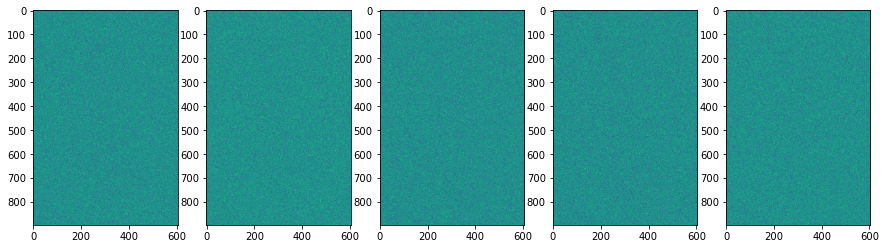

In [18]:
fig,axes=plt.subplots(1,5,figsize=(15,4))

for idx,ax in enumerate(axes) :
    ax.imshow(cproj[idx*20]-nproj[idx*20])

In [ ]:
print(nproj.shape,cproj.shape)

(626, 897, 604)

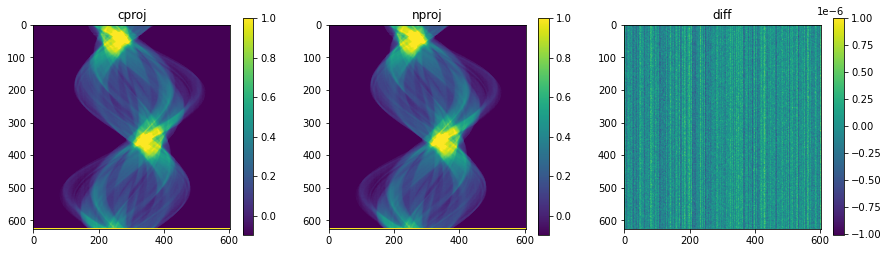

In [19]:
fig,axes=plt.subplots(1,3,figsize=(15,4))
a0=axes[0].imshow(cproj[:,400,:], vmin=-0.1,vmax=1); axes[0].set_title('cproj')
fig.colorbar(a0,ax=axes[0])
a1=axes[1].imshow(nproj[:,400,:], vmin=-0.1,vmax=1); axes[1].set_title('nproj')
fig.colorbar(a1,ax=axes[1])
a2=axes[2].imshow(cproj[:,400,:]-nproj[:,400,:]); axes[2].set_title('diff')
fig.colorbar(a2,ax=axes[2])

cproj.shape

#### Prepare and run the back-projection

In [18]:
ce = imgalg.TomoCenter()

ce.estimate(cproj[0,:,:],cproj[312,:,:],imgalg.centerLeastSquare,True)

(304.1049993691341, 0.3856114402536465, 448.0)

In [19]:
Nproj = cproj.shape[0]
# Information per projection
args = {"angles"  : np.linspace(0,360,num=Nproj), 
        "weights" : np.ones(Nproj)/Nproj
       }

# Geometry information
recon.configure({   "center" : 305, 
                    "resolution" : 0.1
                })
print("have",Nproj,"projections")

have 626 projections


In [20]:
recon.process(cproj[:,500:510,:].astype('float64'),args) # Reconstruct a part of the slices (32 slices here)
del vol
vol = recon.volume() # Retrieve the reconstructed volume

604 10 626


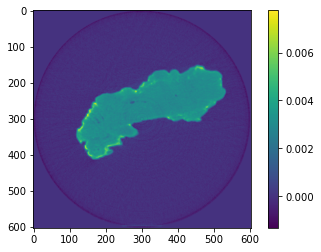

In [21]:
plt.imshow(vol[0])
plt.colorbar()
plt.savefig('recon.png',dpi=300)

In [ ]:
import ipyvolume as ipv

In [ ]:
ipv.quickvolshow(vol)

In [ ]:
print(nproj.flags)
print(cproj.flags)

In [ ]:
a=cproj[:,500:510,:]
b=nproj[:,500:510,:]

# Spotcleaning tests

In [22]:
msc = imgalg.MorphSpotClean()

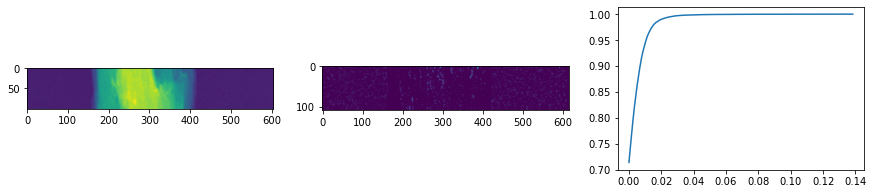

In [46]:
strip= cproj[1,500:600,:]
msc.setCleanMethod(detectionMethod=imgalg.MorphDetectAllSpots, cleanMethod=imgalg.MorphCleanReplace);
d=msc.detectionImage(strip,True)
fig, ax = plt.subplots(1,3,figsize=(15,3))
ax[0].imshow(strip)
ax[1].imshow(d['bright'])
phist,pbins=np.histogram(d['bright'].ravel(), bins=500)
ax[2].plot(pbins[:-1],np.cumsum(phist)/phist.sum())

Text(0.5, 1.0, 'Difference')

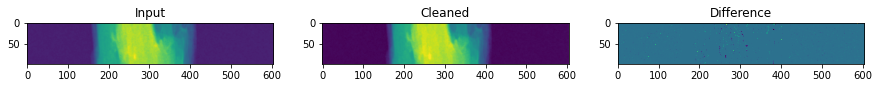

In [56]:
strip= cproj[1,500:600,:].copy()
orig = cproj[1,500:600,:]
msc.process(strip,th=[0.999, 0.999],sigma=[0.01, 0.01])
fig, ax = plt.subplots(1,3,figsize=(15,5))

ax[0].imshow(orig), ax[0].set_title('Input')
ax[1].imshow(strip), ax[1].set_title('Cleaned')
ax[2].imshow(strip-orig,interpolation='none'); ax[2].set_title('Difference')

# Ring cleaning

In [ ]:
sino=cproj[:,500,:]
sorig=sino.copy()
plt.imshow(sino)

In [ ]:
wrc = imgalg.StripeFilter([sino.shape[1],sino.shape[0]],'daub17',3,0.01)

In [ ]:
wrc.process(sino,imgalg.VerticalComponentFFT)

In [ ]:
plt.imshow(sino-sorig,vmin=-0.0005,vmax=0.0005)

In [ ]:
d=sino-sorig
plt.hist(d.ravel(),bins=500);